In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import re

df = pd.read_csv("/content/drive/MyDrive/NLP projektas/math_solutions.csv")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\[abs\]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.replace("\n", " ")
    return text

df["clean_text"] = df["text"].apply(clean_text)

df.head()


,text,type,clean_text
0,We roll a fair 6-sided die 5 times. What is t...,Counting & Probability,We roll a fair 6-sided die 5 times. What is th...
1,"When counting from $3$ to $201$, $53$ is the $...",Counting & Probability,"When counting from $3$ to $201$, $53$ is the $..."
2,Find the value of $n$ that satisfies $2(n+1)!+...,Counting & Probability,Find the value of $n$ that satisfies $2(n+1)!+...
3,I draw a card from a standard 52-card deck. I...,Counting & Probability,I draw a card from a standard 52-card deck. If...
4,How many subsets of the set of divisors of $72...,Counting & Probability,How many subsets of the set of divisors of $72...


In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["type"])

label_names = list(le.classes_)
label_names

['Algebra',
 'Counting & Probability',
 'Geometry',
 'Intermediate Algebra',
 'Number Theory',
 'Prealgebra',
 'Precalculus']

In [18]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=1117
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_id"],
    random_state=1117
)

In [19]:
from transformers import BertTokenizer, TFBertForSequenceClassification

model_name = "tbs17/MathBERT"

tokenizer = BertTokenizer.from_pretrained(model_name)

model = TFBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=7,
    from_pt=True
)

def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="tf"
    )

train_encodings = tokenize_function(train_df["clean_text"])
val_encodings   = tokenize_function(val_df["clean_text"])
test_encodings  = tokenize_function(test_df["clean_text"])

train_labels = train_df["label_id"].values
val_labels   = val_df["label_id"].values
test_labels  = test_df["label_id"].values

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import tensorflow as tf
batch_size = 16

def convert_to_tf_dataset(encodings, labels):
    inputs = {}
    for key in encodings:
        inputs[key] = tf.convert_to_tensor(encodings[key], dtype=tf.int32)
    inputs["labels"] = tf.convert_to_tensor(labels, dtype=tf.int32)
    return tf.data.Dataset.from_tensor_slices(inputs)

train_dataset = convert_to_tf_dataset(train_encodings, train_labels)
val_dataset   = convert_to_tf_dataset(val_encodings,   val_labels)
test_dataset  = convert_to_tf_dataset(test_encodings,  test_labels)

train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [21]:
import tensorflow as tf
batch_size = 16

def make_dataset(encodings, labels, shuffle=False):
    x = dict(encodings)
    y = labels
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(train_encodings, train_labels, shuffle=True)
val_dataset   = make_dataset(val_encodings,   val_labels,   shuffle=False)
test_dataset  = make_dataset(test_encodings,  test_labels,  shuffle=False)

In [22]:
from tensorflow import keras
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_labels

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(zip(np.unique(y_train), weights))
print(class_weights)

{np.int64(0): np.float64(0.6090770636612854), np.int64(1): np.float64(1.434021801491681), np.int64(2): np.float64(1.3249403657566923), np.int64(3): np.float64(0.8124492117666179), np.int64(4): np.float64(1.2673342628977056), np.int64(5): np.float64(0.8598950718156017), np.int64(6): np.float64(1.382658000276587)}


In [24]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
    class_weight=class_weights
)

Epoch 1/4
625/625 [==============================] - 608s 854ms/step - loss: 0.8370 - accuracy: 0.6679 - val_loss: 0.6305 - val_accuracy: 0.7576
Epoch 2/4
625/625 [==============================] - 531s 849ms/step - loss: 0.4735 - accuracy: 0.8063 - val_loss: 0.5850 - val_accuracy: 0.7832
Epoch 3/4
625/625 [==============================] - 531s 850ms/step - loss: 0.3057 - accuracy: 0.8757 - val_loss: 0.6242 - val_accuracy: 0.7832
Epoch 4/4
625/625 [==============================] - 531s 850ms/step - loss: 0.2019 - accuracy: 0.9208 - val_loss: 0.6458 - val_accuracy: 0.7992


In [25]:
model.evaluate(test_dataset)

79/79 [==============================] - 22s 272ms/step - loss: 0.6735 - accuracy: 0.7824


[0.6735410690307617, 0.7824000120162964]

In [26]:
model.save_pretrained("/content/drive/MyDrive/mathbert_finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/mathbert_finetuned")

('/content/drive/MyDrive/mathbert_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/mathbert_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/mathbert_finetuned/vocab.txt',
 '/content/drive/MyDrive/mathbert_finetuned/added_tokens.json')

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    logits = model.predict(x_batch, verbose=0).logits
    preds = np.argmax(logits, axis=1)

    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)


In [28]:
from sklearn.metrics import classification_report, f1_score

macro_f1 = f1_score(y_true, y_pred, average="macro")
print("Macro F1:", macro_f1)
print("\nFull classification report:")
print(classification_report(y_true, y_pred, target_names=label_names))

Macro F1: 0.7847931996650706

Full classification report:
                        precision    recall  f1-score   support

               Algebra       0.82      0.80      0.81       293
Counting & Probability       0.81      0.60      0.69       125
              Geometry       0.81      0.81      0.81       135
  Intermediate Algebra       0.85      0.85      0.85       220
         Number Theory       0.79      0.85      0.82       141
            Prealgebra       0.58      0.73      0.65       207
           Precalculus       0.95      0.81      0.87       129

              accuracy                           0.78      1250
             macro avg       0.80      0.78      0.78      1250
          weighted avg       0.79      0.78      0.78      1250



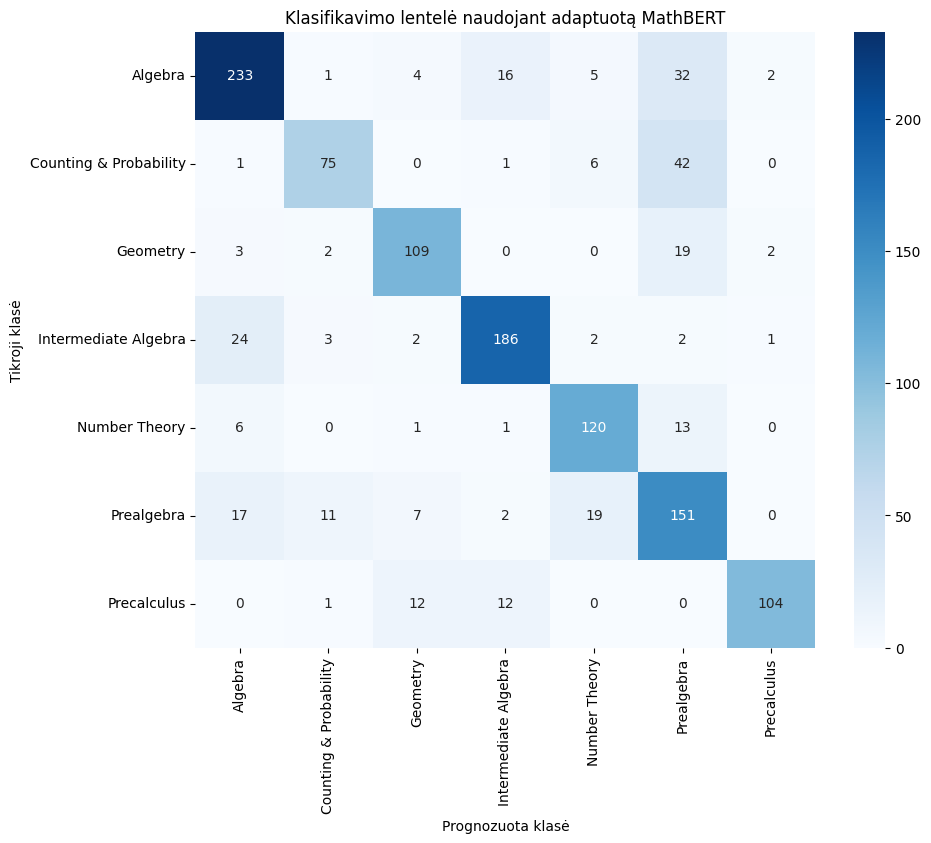

In [30]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.title("Klasifikavimo lentelė naudojant adaptuotą MathBERT")
plt.show()